In [1]:
import math
import numpy as numpy
import matplotlib.pyplot as plt
%matplotlib inline

##### Graphviz

In [2]:
!pip install graphviz
from graphviz import Digraph

In [3]:
def trace(root):
    # build set of all nodes and edges
    nodes, edges = set(), set()

    def build(node):
        # node is not in nodes add it to the list
        if node not in nodes:
            nodes.add(node)

        # for each child of node
        # add an edge from node to child
        # in our case it would be children
        # that is connect all prev to node
        for child in node._prev:
            edges.add((child, node))
            # now recursively call build on each child
            build(child)

    # start building from the root
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR => Left to right

    nodes, edges = trace(root=root)

    for node in nodes:
        # unique id for the node
        uid = str(id(node))

        # for values we create a rectangular shape i.e. record
        dot.node(name = uid, label = "{ %s | data %.2f | grad %.2f}" % (node._label, node.data, node.grad), shape='record')

        # there is a node with operation
        if node._op:
            # i.e, if this is a result of some operation
            dot.node(name = uid + node._op, label = node._op)

            # connect node to it
            dot.edge(uid + node._op, uid)
        
    for n1, n2 in edges:
        # connect node 1 to the op node of node 2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


##### Value Class

In [19]:
class Value:

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        self.grad = 0.0
        # by default and empty function
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self._label = _label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(data=t, _children=(self, ), _label='tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out


In [23]:
# input values
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

# weights
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# bias
b = Value(6.8813735870195432, _label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1._label='x1*w1'
x2w2 = x2 * w2; x2w2._label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label='x1*w1 + x2*w2'

# neuron
n = x1w1x2w2 + b; n._label = 'n'

# output
o = n.tanh(); o._label='o'; o._op='tanh'; o.grad = 1.0

In [24]:
# topological sort
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)

        for child in v._prev:
            build_topo(child)

        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward

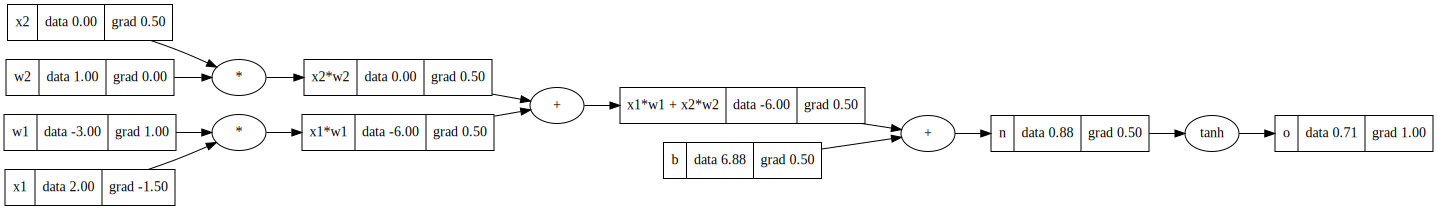

In [25]:
draw_dot(o)